In [70]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt

# Ensures plots are displayed within the notebook
%matplotlib inline


In [68]:
def plot_function(func, xmin=-5, xmax=5, num_points=1000):
    """
    Plots a given function 'func' over the range [xmin, xmax].
    
    Parameters:
    func (function): The function to plot.
    xmin (float): The minimum value of x (default: -5).
    xmax (float): The maximum value of x (default: +5).
    num_points (int): Number of points to generate between xmin and xmax (default: 1000).
    """
    
    # Generate x values
    x_values = np.linspace(xmin, xmax, num_points)
    
    # Compute corresponding y values by applying the function to each x
    y_values = func(x_values)
    
    # Plot the function
    plt.figure(figsize=(8, 6))
    plt.plot(x_values, y_values, label=f'Function: {func.__name__}')
    # plt.title(f'Plot of {func.__name__}')
    plt.xlabel('x')
    plt.ylabel('f(x)')
    plt.grid(True)
    # plt.legend()
    plt.show()

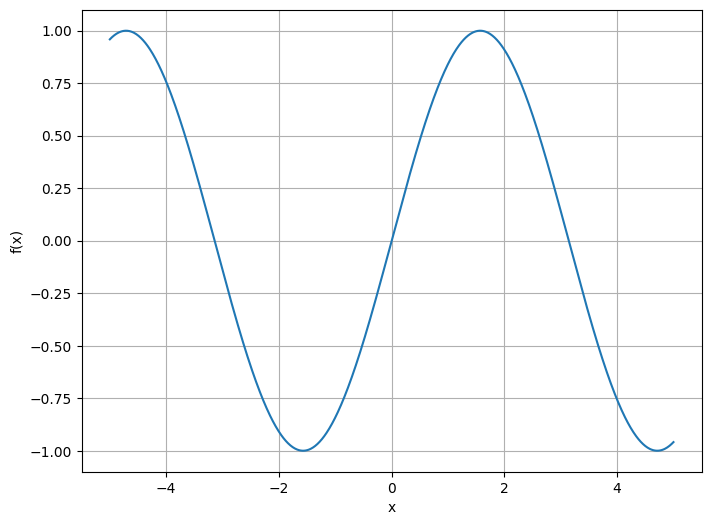

In [3]:
plot_function(np.sin)

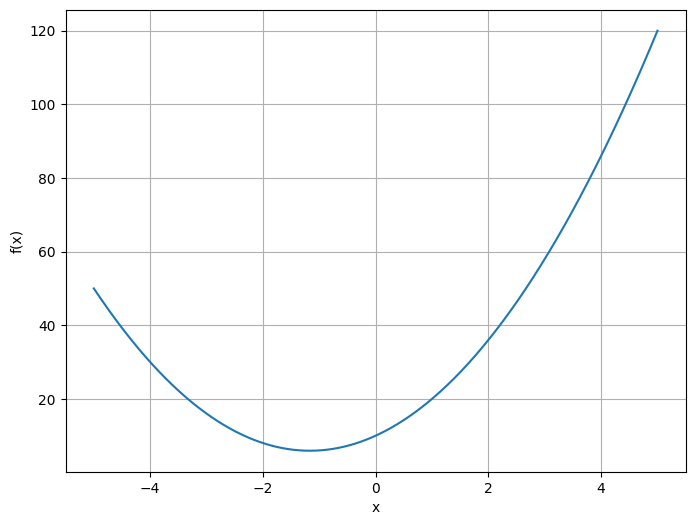

In [4]:
plot_function(lambda x: 3*x**2 + 7*x + 10)

# Micrograd building blocks

Building micrograd requires the follows:
- A `Value` class which handles individual numeric values.
- A `Neuron` class which handles an individual Neuron in the MLP
- A `Layer` class which handles an array of neurons
- A `MLP` class which handles the full MLP which is a concatenation of many `Layer` objects. 

## `Value` class

In [123]:
class Value:
    def __init__(self, value, label='', pred=(), op=''):
        self.value = value
        self.label = label
        self._pred = pred
        self._op = op
        self.grad = 0
        self._backward = lambda: None

    def __repr__(self):
      return f"Value(data={self.value}, label='{self.label}')"

    def __add__(self, other):
        other = Value(other) if isinstance(other, (int, float)) else other
        result = self.value + other.value
        out = Value(result, pred=(self, other), op='+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad

        out._backward = _backward

        return out
    
    def __radd__(self, other):
        return self + other
    
    def __mul__(self, other):
        other = Value(other) if isinstance(other, (int, float)) else other
        result = self.value * other.value
        out = Value(result, pred=(self, other), op='*')

        def _backward():
            self.grad += other.value * out.grad
            other.grad += self.value * out.grad

        out._backward = _backward

        return out
    
    def __rmul__(self, other):
        return self * other
    
    def __sub__(self, other):
        return self + -1*other
    
    def __rsub__(self, other):
        return (self - other) * (-1)
    
    def __pow__(self, other):
        assert isinstance(other, (int, float))

        result = (self.value)**other
        out = Value(result, pred=(self,), op=f'**{other}')

        def _backward():
            self.grad += other * ((self.value)**(other-1)) * out.grad

        out._backward = _backward

        return out
    
    def __truediv__(self, other):
        return self * other ** (-1)
    
    def __rtruediv__(self, other):
        return (self/other) ** (-1)
    
    def exp(self):
        result = np.exp(self.value)
        out = Value(result, pred=(self,), op='exp')

        def _backward():
            self.grad += out.value * out.grad

        out._backward = _backward

        return out
    
    def sigmoid(self):
        return 1 / (1 + self.exp())

    def tanh(self):
        power_term = self * 2
        e = power_term.exp()
        return (e - 1)/(e + 1)

    def backward(self):
        def topological_sort(node):
            visited = set()  # Set to keep track of visited nodes
            stack = []       # Stack to store the topological order

            def dfs(node):
                if node in visited:
                    return
                visited.add(node)
                for predecessor in node._pred:
                    dfs(predecessor)
                stack.append(node)

            dfs(node)

            # Reverse the stack to get the topological order
            stack.reverse()
            return stack
        
        topo_sort = topological_sort(self)
        
        self.grad = 1.0
        for node in topo_sort:
            node._backward()

In [124]:
a = Value(1, label='a')
b = Value(2.5, label='b')
c = Value(1.4, label='c')

In [125]:
1-c

Value(data=-0.3999999999999999, label='')

## Graph visualisation

In [126]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._pred:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | value %.4f | grad %.4f}" % (n.label ,n.value, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

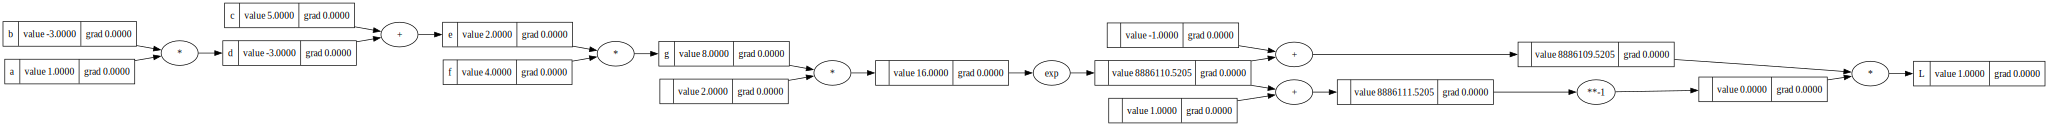

In [127]:
a = Value(1, label='a')
b = Value(-3, label='b')
c = Value(5, label='c')
d = a * b; d.label = 'd'
e = d + c; e.label = 'e'
f = Value(4, label='f')
g = e * f; g.label = 'g'
L = g.tanh(); L.label = 'L'
draw_dot(L)

## Manual grad calculation

Using formula

In [61]:
g.grad = 1.0
e.grad = f.value * g.grad 
f.grad = e.value * g.grad
c.grad = e.grad ## dc/dg = dc/de * de/dg
d.grad = e.grad ## dd/dg = dd/de * de/dg
a.grad = b.value * d.grad ## da/dg = da/dd * dd/dg
b.grad = a.value * d.grad ## db/dg = db/dd * dd/dg

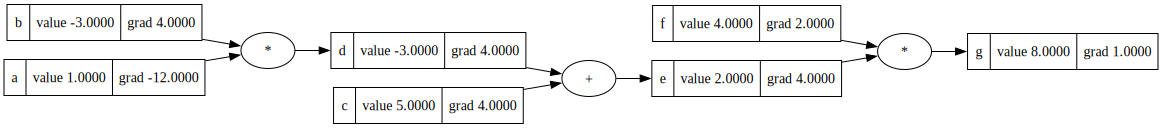

In [62]:
draw_dot(g)

Using a function and determining the movement using small changes

In [65]:
def grad_numeric():
    h = 0.0001
    a = Value(1, label='a')
    b = Value(-3, label='b')
    c = Value(5, label='c')
    d = a * b; d.label = 'd'
    e = d + c; e.label = 'e'
    f = Value(4, label='f')
    g = e * f; g.label = 'g'
    g1 = g.value

    a = Value(1, label='a')
    b = Value(-3 + h, label='b')
    c = Value(5, label='c')
    d = a * b; d.label = 'd'
    e = d + c; e.label = 'e'
    f = Value(4, label='f')
    g = e * f; g.label = 'g'
    g2 = g.value

    print((g2-g1)/h)

grad_numeric()

4.000000000008441


Next, we can see the effect of the gradient to increase the value of g

In [66]:
## Increase leaf nodes a, b, c and f in direction of their gradients
a += 0.01 * a.grad
b += 0.01 * b.grad
c += 0.01 * c.grad
f += 0.01 * f.grad

d = a * b; d.label = 'd'
e = d + c; e.label = 'e'
g = e * f; g.label = 'g'

g

Value(data=9.789503999999999, label='g')

## Build a neuron and backpropagate through that

![Neuron image](./neuron.webp)

Lets create a simple 2 input neuron using the Value class

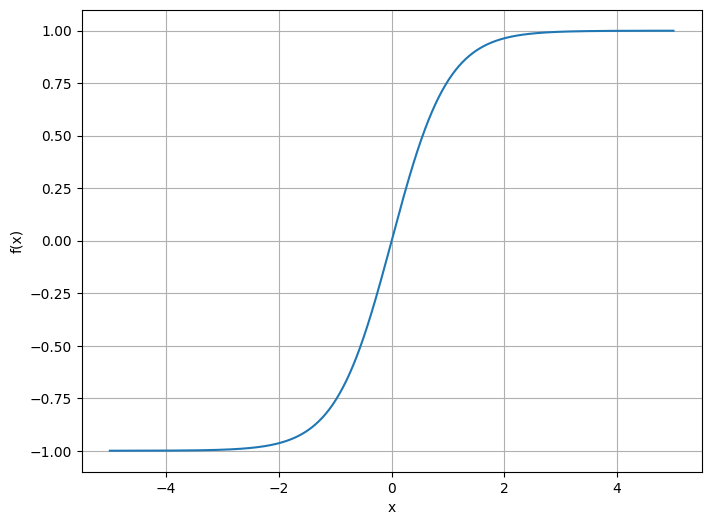

In [71]:
plot_function(np.tanh)

In [55]:
np.random.seed(42)

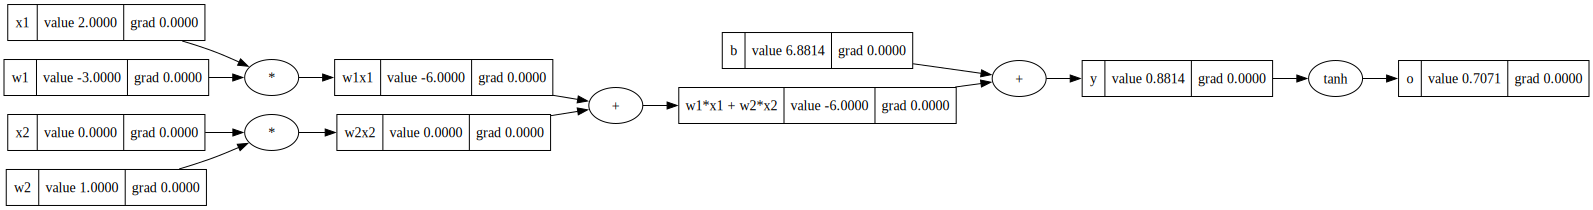

In [85]:
w1 = Value(-3.0, label='w1')
x1 = Value(2.0, label='x1')

w2 = Value(1.0, label='w2')
x2 = Value(0.0, label='x2')

b = Value(6.881373587, label='b')

w1x1 = w1 * x1; w1x1.label = 'w1x1'
w2x2 = w2 * x2; w2x2.label = 'w2x2'

w1x1w2x2 = w1x1 + w2x2; w1x1w2x2.label = "w1*x1 + w2*x2"
y = w1x1w2x2 + b; y.label = 'y'
o = y.tanh(); o.label = 'o'
draw_dot(o)

Compute the gradients manually

In [88]:
o.grad = 1

y.grad = (1 - (o.value)**2) * o.grad ## dy/do = d (tanh (o))/do = 1 - (tanh)**2 = 1-o**2

b.grad = y.grad ## db/do = db/dy * dy/do
w1x1w2x2.grad = y.grad 

w1x1.grad = w1x1w2x2.grad ## dw1x1/do = dw1x1/dw1x1w2x2 * dw1x1w2x2/do
w2x2.grad = w1x1w2x2.grad

w1.grad = x1.value * w1x1.grad ##dw1/do = dw1/dw1x1 * dw1x1/do
x1.grad = w1.value * w1x1.grad
w2.grad = x2.value * w2x2.grad
x2.grad = w2.value * w2x2.grad

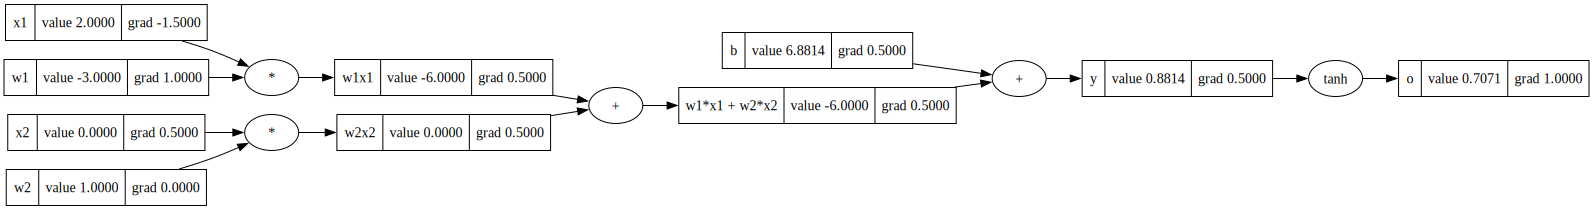

In [89]:
draw_dot(o)

Using the `_backward` function we defined

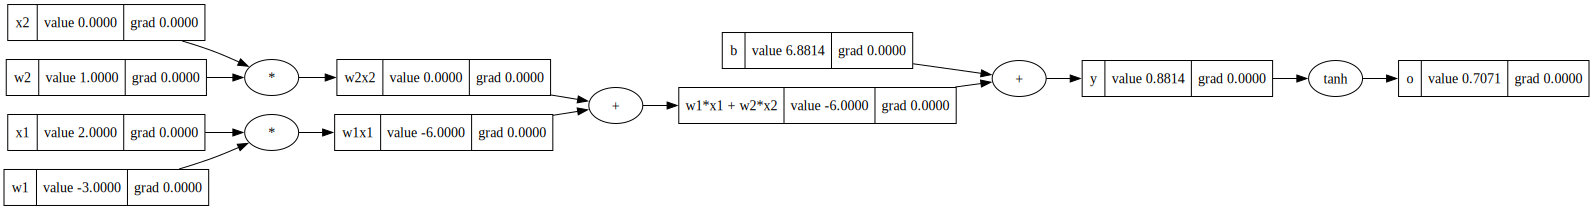

In [97]:
w1 = Value(-3.0, label='w1')
x1 = Value(2.0, label='x1')

w2 = Value(1.0, label='w2')
x2 = Value(0.0, label='x2')

b = Value(6.881373587, label='b')

w1x1 = w1 * x1; w1x1.label = 'w1x1'
w2x2 = w2 * x2; w2x2.label = 'w2x2'

w1x1w2x2 = w1x1 + w2x2; w1x1w2x2.label = "w1*x1 + w2*x2"
y = w1x1w2x2 + b; y.label = 'y'
o = y.tanh(); o.label = 'o'
draw_dot(o)

In [98]:
o.grad = 1
o._backward()

y._backward()

w1x1w2x2._backward()
b._backward()

w1x1._backward()
w2x2._backward()

w1._backward()
x1._backward()
w2._backward()
x2._backward()

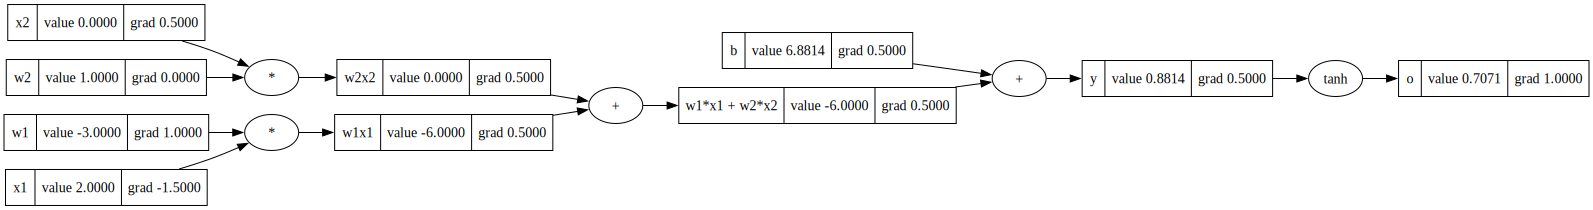

In [77]:
draw_dot(o)

## Implement a full fledged backward function

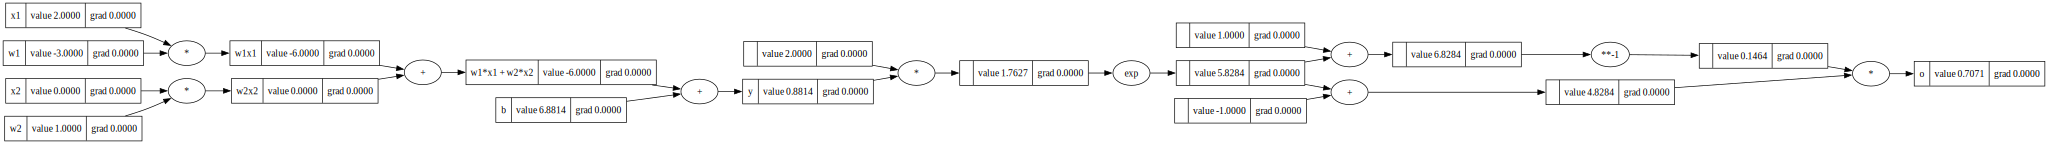

In [128]:
w1 = Value(-3.0, label='w1')
x1 = Value(2.0, label='x1')

w2 = Value(1.0, label='w2')
x2 = Value(0.0, label='x2')

b = Value(6.881373587, label='b')

w1x1 = w1 * x1; w1x1.label = 'w1x1'
w2x2 = w2 * x2; w2x2.label = 'w2x2'

w1x1w2x2 = w1x1 + w2x2; w1x1w2x2.label = "w1*x1 + w2*x2"
y = w1x1w2x2 + b; y.label = 'y'
o = y.tanh(); o.label = 'o'
draw_dot(o)

In [129]:
o.backward()

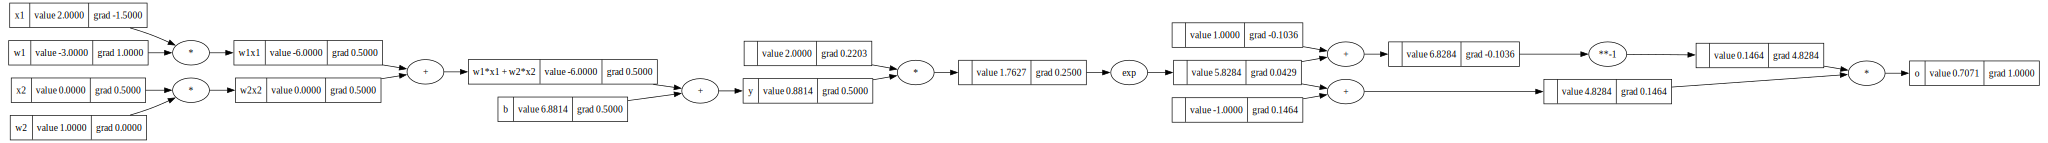

In [130]:
draw_dot(o)

Check edge case of repeated node

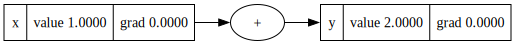

In [115]:
x = Value(1.0, label='x')
y = x + x; y.label = 'y'
draw_dot(y)

In [116]:
y.backward()

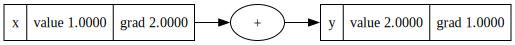

In [117]:
draw_dot(y)

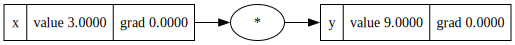

In [118]:
x = Value(3.0, label='x')
y = x * x; y.label = 'y'
draw_dot(y)

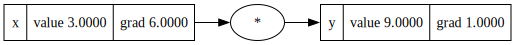

In [119]:
y.backward()
draw_dot(y)

## Implement the above NN in PyTorch

In [133]:
import torch

w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
b = torch.Tensor([6.881373587]).double(); b.requires_grad = True

y = w1*x1 + w2*x2 + b
o = torch.tanh(y)

print(o.data.item())
o.backward()

print(f"x1 grad: {x1.grad.item()}")
print(f"w1 grad: {w1.grad.item()}")
print(f"x2 grad: {x2.grad.item()}")
print(f"w2 grad: {w2.grad.item()}")
print(f"b grad: {b.grad.item()}")

0.7071066904050358
x1 grad: -1.5000003851533106
w1 grad: 1.0000002567688737
x2 grad: 0.5000001283844369
w2 grad: 0.0
b grad: 0.5000001283844369


## Implement the single neuron as a class

A neuron will take `nin` inputs and combine them with weights and biases, apply an activation function and return a single output

In [200]:
class Neuron:
    def __init__(self, nin, activation='tanh'):
        weights = np.random.randn(nin)
        bias = np.random.randn()

        self.w = [Value(weight) for weight in weights]
        self.b = Value(bias)
        self.activation = activation

    def __call__(self, x):
        """
        Input:
            x: List of Values of size nin
        """

        y = sum([self.w[i] * x[i] for i in range(len(x))], self.b)

        if self.activation == 'sigmoid':
            o = y.sigmoid()
        elif self.activation == 'tanh':
            o = y.tanh()

        return o
    
    def zero_grad(self):
        for w in self.w:
            w.grad = 0

        self.b.grad = 0

    def params(self):
        return self.w + [self.b]

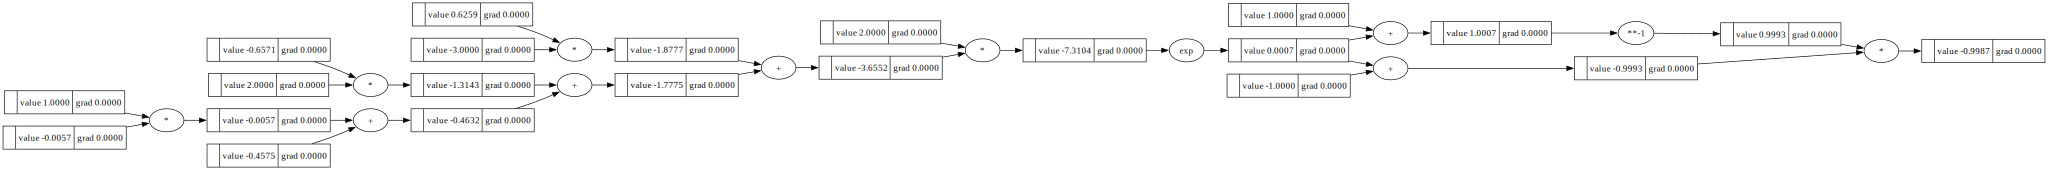

In [152]:
neuron = Neuron(3)
x = [Value(1.0), Value(2.0), Value(-3.0)]

y = neuron(x)
draw_dot(y)

## Define a `Layer` of `Neuron`s

`Layer` is simply a collection of `nout` Neurons

In [201]:
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        return [neuron(x) for neuron in self.neurons]
    
    def zero_grad(self):
        for neuron in self.neurons:
            neuron.zero_grad()

    def params(self):
        return [p for neuron in self.neurons for p in neuron.params()]

## Now define the `MLP`

It will have a `nin` and some `nouts` with dimensionality of the hidden layers and output layer

In [202]:
class MLP:
    def __init__(self, nin, nouts):
        """
        Input:
            nin: Integer, no. of input params
            nout: List of integers, dimensionality of each of the hidden layers and the output layer
        """
        dim_list = [nin] + nouts
        self.layers = [Layer(dim_list[i], dim_list[i + 1]) for i in range(len(nouts))]

    def __call__(self, x):
        """
        Input:
            x: List of values of size nin
        """
        out = x
        for layer in self.layers:
            out = layer(out)

        return out[0] if len(out)==1 else out
    
    def zero_grad(self):
        for layer in self.layers:
            layer.zero_grad()

    def params(self):
        return [p for layer in self.layers for p in layer.params()]

In [203]:
mlp = MLP(3, [6, 6, 1])

x = np.random.randn(4, 3)
y = [1.0, 1.0, -1.0, -1.0]

y_pred = [mlp(xi) for xi in x]
y_pred

[Value(data=0.6086137945008006, label=''),
 Value(data=-0.952718742821071, label=''),
 Value(data=0.9694043677179789, label=''),
 Value(data=0.9698811467613571, label='')]

In [204]:
L = sum((y_i - y_pred_i)**2 for y_i, y_pred_i in zip(y, y_pred)) ## simple MSE loss
L

Value(data=11.725278946372256, label='')

In [197]:
L.backward()

In [199]:
mlp.params()

[Value(data=-0.20709176227205736, label=''),
 Value(data=-0.41762306480803674, label=''),
 Value(data=-0.7102953321494059, label=''),
 Value(data=0.2876778022405012, label=''),
 Value(data=0.7742490054892756, label=''),
 Value(data=-1.5859006318383928, label=''),
 Value(data=-0.38579902162621227, label=''),
 Value(data=0.24882936875894118, label=''),
 Value(data=1.6171597499255206, label=''),
 Value(data=1.0317060175938535, label=''),
 Value(data=-0.7611217255590389, label=''),
 Value(data=0.373801809998287, label=''),
 Value(data=0.8702857090630759, label=''),
 Value(data=-0.28277159692032616, label=''),
 Value(data=-0.5578186079354638, label=''),
 Value(data=0.33275198782030385, label=''),
 Value(data=-1.272300349301843, label=''),
 Value(data=-1.2258037544770655, label=''),
 Value(data=1.5363110709041885, label=''),
 Value(data=-0.7036036763014878, label=''),
 Value(data=-0.7694457688606483, label=''),
 Value(data=-1.1510504224302787, label=''),
 Value(data=0.18049318810934808, labe

## Implement complete backprop for an MLP

In [210]:
class Neuron:
    def __init__(self, nin, activation='tanh'):
        weights = np.random.randn(nin)
        bias = np.random.randn()

        self.w = [Value(weight) for weight in weights]
        self.b = Value(bias)
        self.activation = activation

    def __call__(self, x):
        """
        Input:
            x: List of Values of size nin
        """

        y = sum([self.w[i] * x[i] for i in range(len(x))], self.b)

        if self.activation == 'sigmoid':
            o = y.sigmoid()
        elif self.activation == 'tanh':
            o = y.tanh()

        return o

    def params(self):
        return self.w + [self.b]
    
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        return [neuron(x) for neuron in self.neurons]

    def params(self):
        return [p for neuron in self.neurons for p in neuron.params()]
    
class MLP:
    def __init__(self, nin, nouts):
        """
        Input:
            nin: Integer, no. of input params
            nout: List of integers, dimensionality of each of the hidden layers and the output layer
        """
        dim_list = [nin] + nouts
        self.layers = [Layer(dim_list[i], dim_list[i + 1]) for i in range(len(nouts))]

    def __call__(self, x):
        """
        Input:
            x: List of values of size nin
        """
        out = x
        for layer in self.layers:
            out = layer(out)

        return out[0] if len(out)==1 else out

    def params(self):
        return [p for layer in self.layers for p in layer.params()]
    
    def zero_grad(self):
        for p in self.params():
            p.grad = 0.0

In [211]:
mlp = MLP(3, [6, 6, 1])

x = [[2.0, 3.0, -1.0],
     [3.0, 1.0, -0.5],
     [0.5, 1.0, 1.0],
     [1.0, 1.0, -1.0]]
y = [1.0, -1.0, -1.0, 1.0]

num_epochs = 20
lr = 0.1

for i in range(num_epochs):
    ## Predictions
    y_pred = [mlp(xi) for xi in x]
    ## Loss computation
    L = sum((y_i - y_pred_i)**2 for y_i, y_pred_i in zip(y, y_pred))## simple MSE loss
    ## Get the grads
    L.backward()
    ## Modify the parameters for the MLP
    for param in mlp.params():
        param.value -= lr * param.grad

    ## Set the grad back to 0
    mlp.zero_grad()

    print(f"Epoch {i+1} Loss: {L.value}")


Epoch 1 Loss: 7.438874552377751
Epoch 2 Loss: 3.6414250610114274
Epoch 3 Loss: 7.916290301760981
Epoch 4 Loss: 7.8783922585129496
Epoch 5 Loss: 7.7729582435177775
Epoch 6 Loss: 7.110228760802151
Epoch 7 Loss: 2.316250529393361
Epoch 8 Loss: 1.160187874950005
Epoch 9 Loss: 1.3496023375562203
Epoch 10 Loss: 6.413141999117925
Epoch 11 Loss: 7.005600046172059
Epoch 12 Loss: 0.11674697660935106
Epoch 13 Loss: 0.06265648564615975
Epoch 14 Loss: 0.04593996932449337
Epoch 15 Loss: 0.03737085388164958
Epoch 16 Loss: 0.03199953363025661
Epoch 17 Loss: 0.028252803259262216
Epoch 18 Loss: 0.025454077112347262
Epoch 19 Loss: 0.023261637600886984
Epoch 20 Loss: 0.02148336969707918


In [212]:
y_pred = [mlp(xi) for xi in x]
y_pred

[Value(data=0.9330176253374517, label=''),
 Value(data=-0.8976056162900801, label=''),
 Value(data=-0.9649723637967306, label=''),
 Value(data=0.9383208368086261, label='')]